# Face Alignments (algorithm from FFHQ dataset)
* [ref](https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py)

In [1]:
import os
import json
import shutil
import random
import concurrent.futures
from pathlib import Path
from functools import partial
from collections.abc import Sequence

import cv2
import numpy as np
import scipy.ndimage
import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import cm
from tqdm import tqdm
from IPython.display import display

In [2]:
import matplotlib as mpl
mpl.rcParams['text.color'] = 'white'
import matplotlib.pyplot as plt

In [3]:
landmarks = json.load(open('df_landmarks.json', 'r'))
print("total:", len(landmarks))

total: 27900


In [4]:
id_split = {p.stem: p.parts[-2] for p in Path('AB_RGBA_quad').glob('**/*.png')}

In [4]:
def recreate_aligned_images(item, output_size=1024, transform_size=4096, enable_padding=True, ratio=2.0, save=False, mask_mode='quad', return_stats=False):
    # Load in-the-wild image.
    src_file = Path(item['in_the_wild']['file_path'])
    assert src_file.is_file()
    assert mask_mode in ['quad', 'box']
    if return_stats:
        # return keypoint for statistical analysis
        assert not isinstance(ratio, Sequence)
        assert save is False

    # Parse landmarks.
    # pylint: disable=unused-variable
    lm = np.array(item['in_the_wild']['face_landmarks'])
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    
    if isinstance(ratio, (tuple, list)):
        # just for tune scale ratio for my dataset
        negs = []
        for r in ratio:
            x_max = x * max(np.hypot(*eye_to_eye) * r, np.hypot(*eye_to_mouth) * r * 0.9)
            y = np.flipud(x_max) * [-1, 1]
            c = eye_avg + eye_to_mouth * 0.1
            quad = np.stack([c - x_max - y, c - x_max + y, c + x_max + y, c + x_max - y])
            negs.append((quad < 0).any())

        return src_file.stem, negs

    x *= max(np.hypot(*eye_to_eye) * ratio, np.hypot(*eye_to_mouth) * ratio * 0.9)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])

    if return_stats:
        return c, x, np.hypot(*eye_to_eye) * ratio > np.hypot(*eye_to_mouth) * ratio * 0.9
    
    raw_quad = quad.copy()
    qsize = np.hypot(*x) * 2

    img = Image.open(src_file)
    whole_body = img.resize((output_size, output_size), Image.ANTIALIAS)
    
    # masked body
    img_np = np.array(img)
    mask = np.zeros(img.size, dtype=np.uint8)
    if mask_mode == 'box':
        x1, y1, w, h = item['in_the_wild']['box']
        x2, y2 = x1 + w, y1 + h
        q = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]], np.int32)
    else:
        # quad
        q = quad # * (output_size / img.size[0])
        # q = np.where(q < 0, 0, q)
        q = q.astype(np.int32)
    cv2.fillPoly(mask, [q], (255, 255, 255))
    masked_body = np.concatenate([img_np, mask[..., None]], axis=-1)
    masked_body = Image.fromarray(masked_body, mode='RGBA').resize((output_size, output_size), Image.ANTIALIAS)
    # masked_body = masked_body.resize((output_size, output_size), Image.ANTIALIAS)

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # display(img)
    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), Image.QUAD, (quad + 0.5).flatten(), Image.BILINEAR)
    if output_size < transform_size:
        face = img.resize((output_size, output_size), Image.ANTIALIAS)
        
    if save:
        face.save(OUTDIR / 'face' / f'{src_file.stem}.png')
        masked_body.save(OUTDIR / 'masked_body' / f'{src_file.stem}.png')

    return face, whole_body, masked_body, raw_quad

### Adjust eye_to_eye ratio & eye_to_mouth ratio

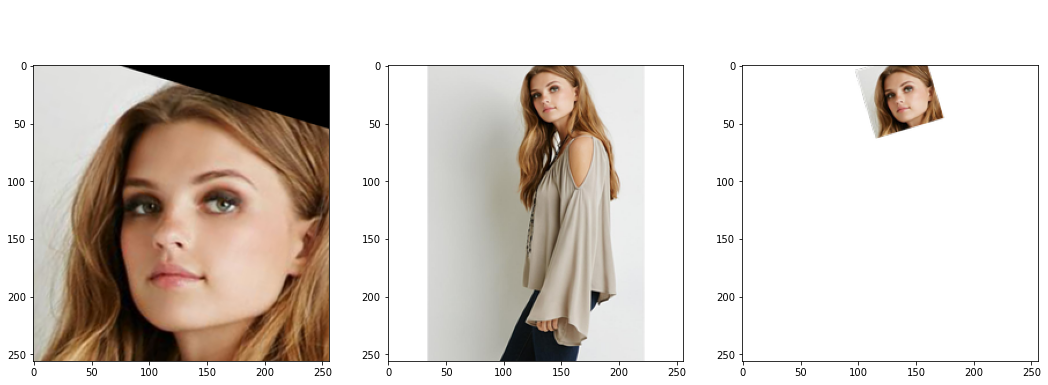

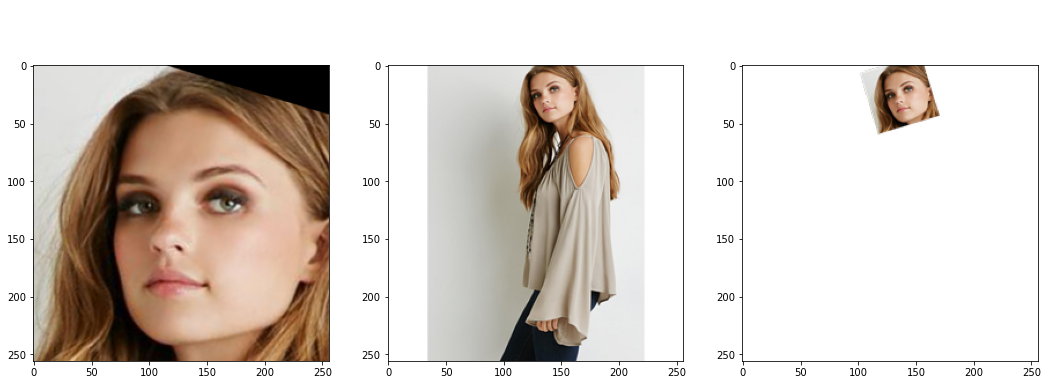

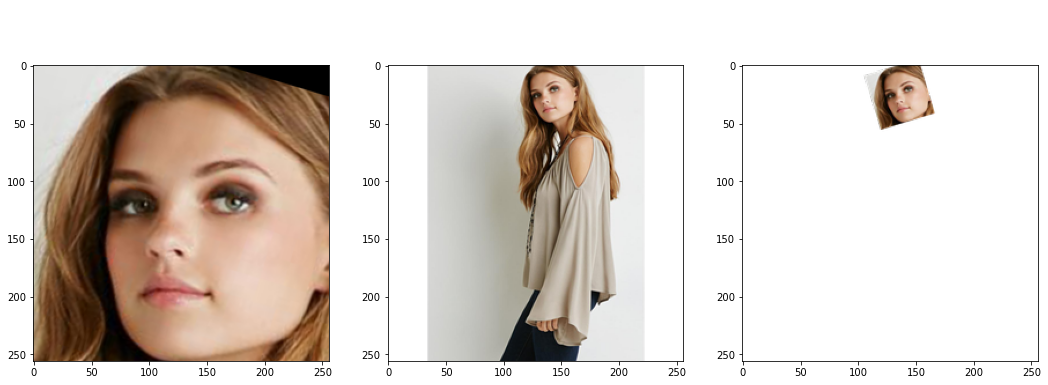

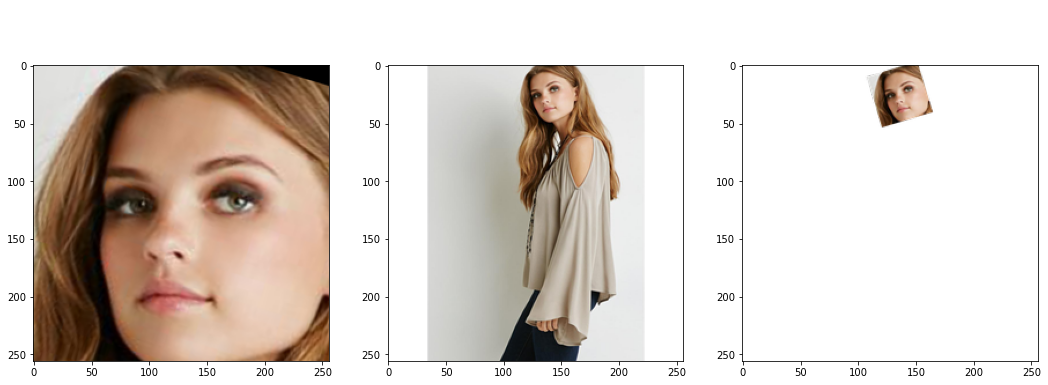

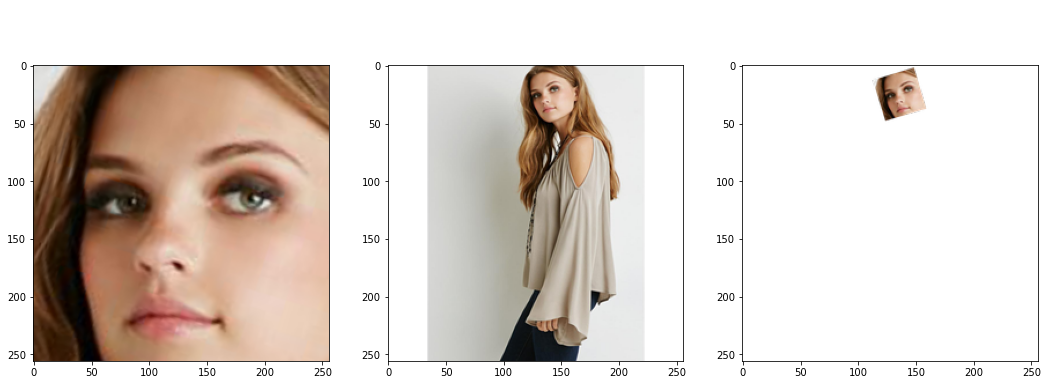

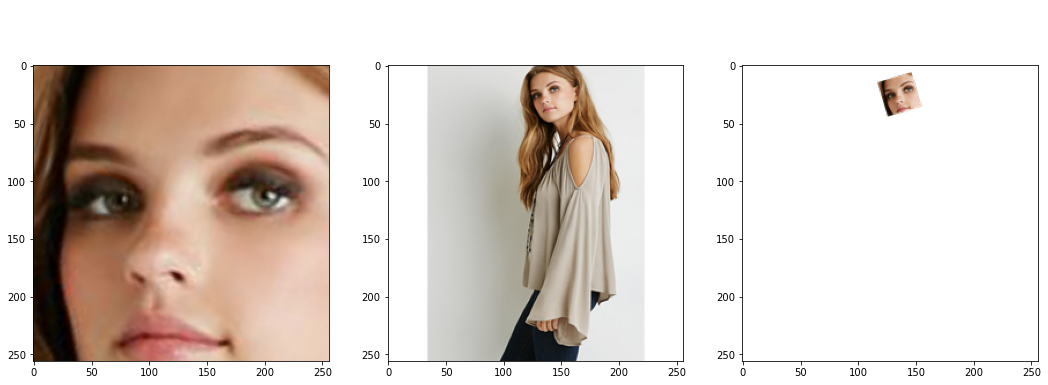

In [17]:
lm = [l for l in landmarks.values() if l['in_the_wild']['file_path'].split('/')[-1] == 'id_00000004_05_2_side.jpg'][0]
for ratio in [2.0, 1.8, 1.6, 1.5, 1.2, 1.0]:
    face, whole_body, masked_body, _ = recreate_aligned_images(lm, output_size=256, transform_size=1024, enable_padding=False, ratio=ratio)
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    for axes, name in zip(ax, ['face', 'whole_body', 'masked_body']):
        axes.set_title(name)
        axes.imshow(locals()[name])
    fig.suptitle(ratio)
    display(fig)
    plt.close(fig)

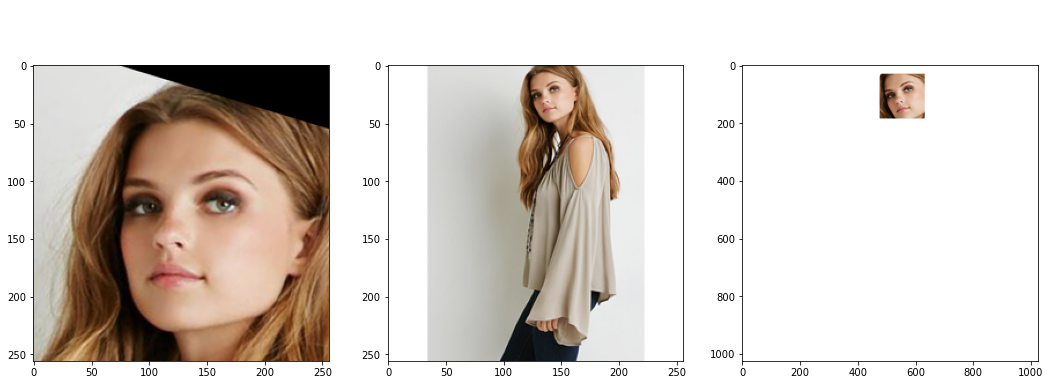

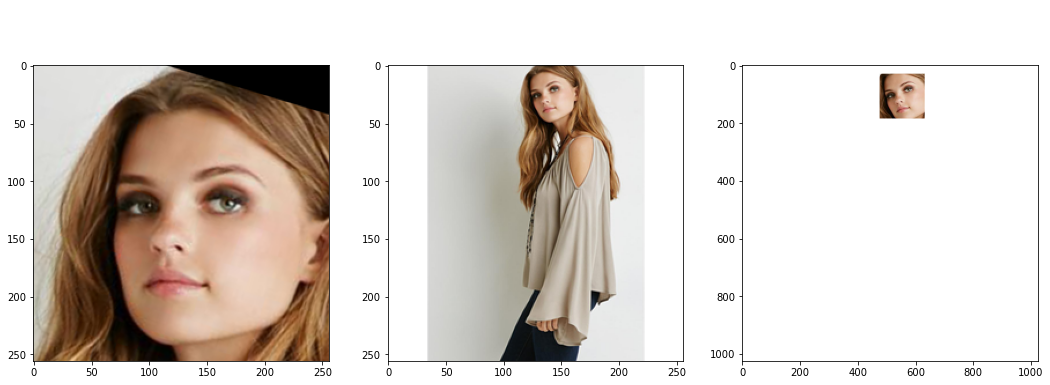

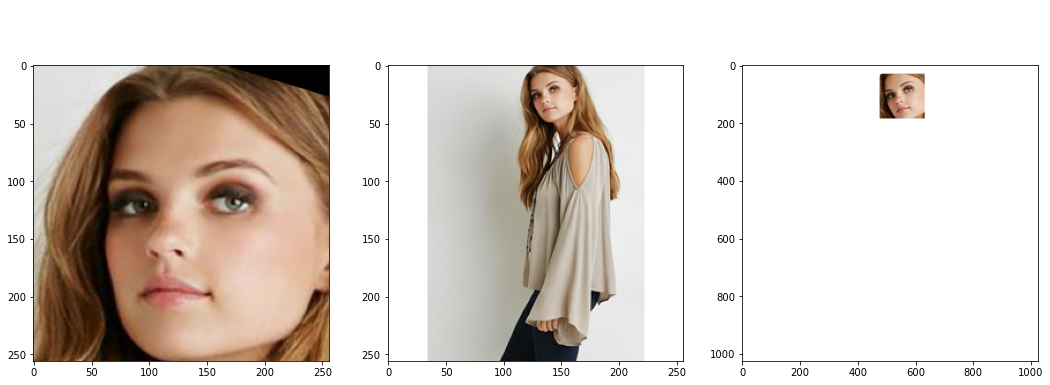

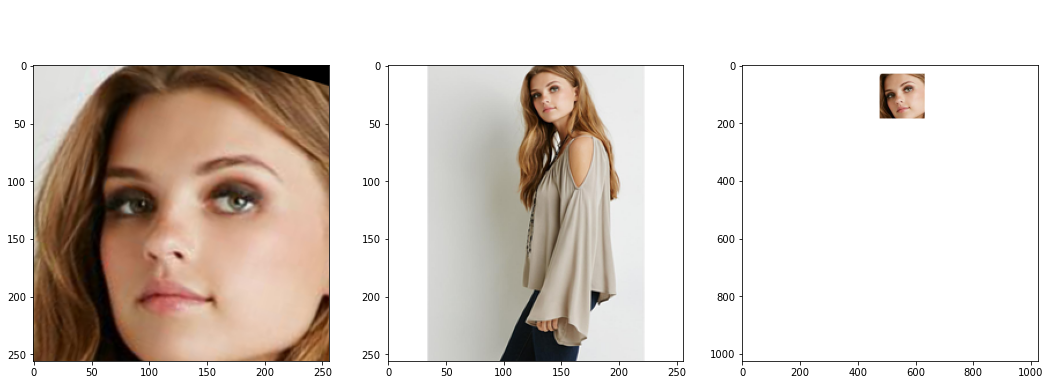

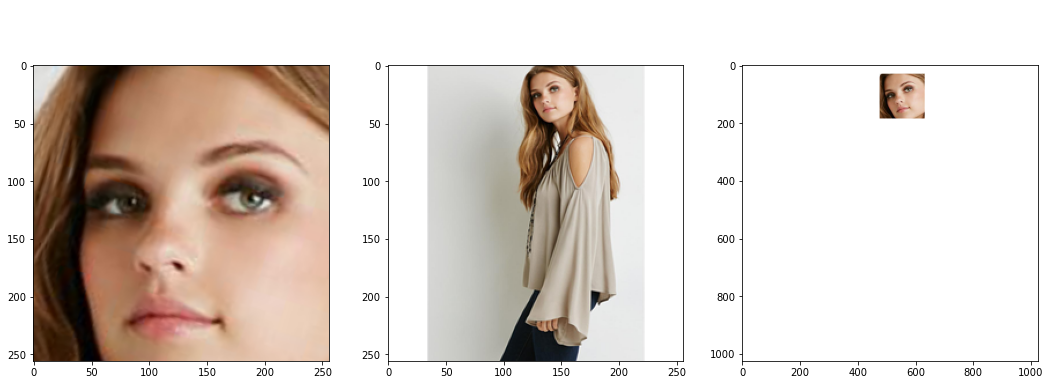

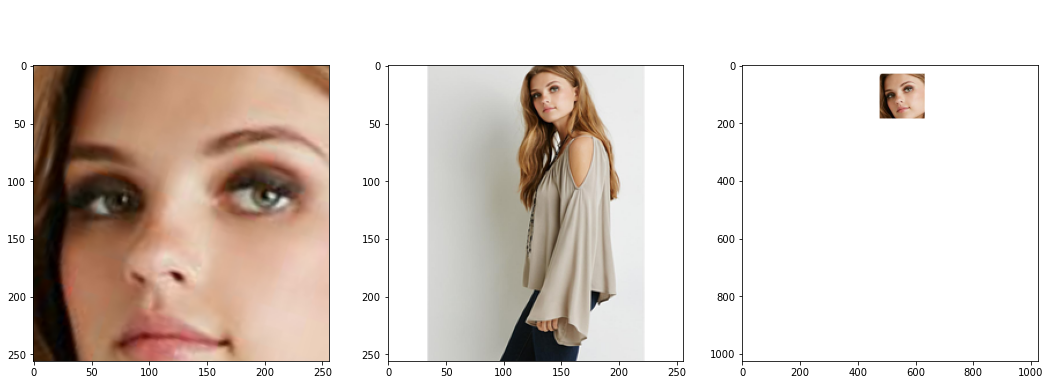

In [13]:
lm = [l for l in landmarks.values() if l['in_the_wild']['file_path'].split('/')[-1] == 'id_00000004_05_2_side.jpg'][0]
for ratio in [2.0, 1.8, 1.6, 1.5, 1.2, 1.0]:
    face, whole_body, masked_body, _ = recreate_aligned_images(lm, output_size=256, transform_size=1024, enable_padding=False, ratio=ratio, mask_mode='box')
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    for axes, name in zip(ax, ['face', 'whole_body', 'masked_body']):
        axes.set_title(name)
        axes.imshow(locals()[name])
    fig.suptitle(ratio)
    display(fig)
    plt.close(fig)

## Count how many images with negative quad coordinates

In [24]:
pset = set([p.stem for p in Path('AB_RGBA_quad/').glob('**/*.png')])
landmark_list = [lm for lm in landmarks.values() if Path(lm['in_the_wild']['file_path']).is_file() and Path(lm['in_the_wild']['file_path']).stem in pset]
total = len(landmark_list)
total

27751

In [25]:
cnt = 0
ratios = [round(x * 0.1, 2) for x in range(10, 21)]
neg_stats = {split: {str(ratio): 0 for ratio in ratios} for split in ['train', 'val', 'test']}
align_func = partial(recreate_aligned_images, output_size=256, transform_size=1024, ratio=ratios)
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(align_func, landmark_list)

    for result in results:
        file_id, negs = result
        
        for neg, ratio in zip(negs, ratios):
            neg_stats[id_split[file_id]][str(ratio)] += int(neg)
                
        cnt += 1
        print(f"{cnt} / {total}", end='\r')
        
msg = f'\ntotal: {total}\n'
for split, cnt in neg_stats.items():
    msg += f"{split}:\t{cnt}\n"
    
print(msg)

27751 / 27751
total: 27751
train:	{'1.0': 162, '1.1': 256, '1.2': 439, '1.3': 744, '1.4': 1252, '1.5': 2028, '1.6': 3237, '1.7': 4809, '1.8': 6697, '1.9': 8633, '2.0': 10387}
val:	{'1.0': 35, '1.1': 61, '1.2': 95, '1.3': 166, '1.4': 286, '1.5': 449, '1.6': 738, '1.7': 1152, '1.8': 1585, '1.9': 2032, '2.0': 2428}
test:	{'1.0': 2, '1.1': 3, '1.2': 3, '1.3': 6, '1.4': 14, '1.5': 18, '1.6': 36, '1.7': 57, '1.8': 79, '1.9': 102, '2.0': 124}



In [29]:
%%time

OUTDIR = Path('align_1.2')
if OUTDIR.exists():
    shutil.rmtree(OUTDIR)
(OUTDIR / 'face').mkdir(parents=True)
(OUTDIR / 'masked_body').mkdir(parents=True)

cnt = 0
align_func = partial(recreate_aligned_images, output_size=256, transform_size=1024, enable_padding=True, ratio=1.2, save=True, mask_mode='quad')
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(align_func, landmark_list)
    
    for _ in results:
        cnt += 1
        print(f"{cnt} / {total}", end='\r')
print()

CPU times: user 57min 53s, sys: 35.8 s, total: 58min 29s
Wall time: 7min


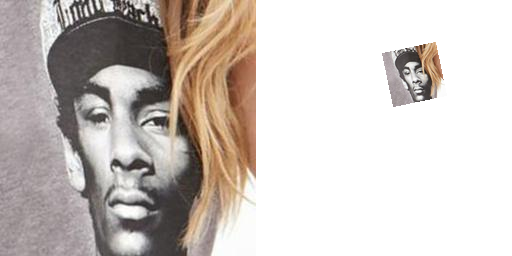

In [58]:
Image.open('AB_RGBA_quad/train/id_00000007_01_2_side.png') # 漏網之魚

### Statistics

In [16]:
p_set = set([p.stem for p in Path('AB_RGBA_quad/').glob('**/*.png')])
lm_in_interest = [lm for lm in landmarks.values() if Path(lm['in_the_wild']['file_path']).stem in p_set]

In [49]:
cs, xs, eye2eye = [], [], []
# id2cx = {}
for item in lm_in_interest:
    c, x, t = recreate_aligned_images(item, ratio=1.2, return_stats=True)
    cs.append(c)
    xs.append(x)
    eye2eye.append(t)
    # id2cx[Path(item['in_the_wild']['file_path']).stem] = dict(x=x, c=c, flag=t)
    
cs = np.array(cs)
xs = np.array(xs)
eye2eye = np.array(eye2eye)

In [13]:
x_norm = np.linalg.norm(xs, axis=1)

In [14]:
def cart2pol(p):
    x, y = p
    rho = np.sqrt(x**2 + y**2)
    phi = (np.arctan2(y, x)) % (2 * np.pi)
    return(rho, phi)

### X NORM
* 有兩個分佈，但不大像 Gaussian
* 與取 eye2eye 或是 eye2mouth 無關（橘色與綠色也各都分成兩部分）
* eye2mouth 數量與平均都比 eye2eye 小

In [57]:
print(x_norm[x_norm > 55].mean(), x_norm[x_norm > 55].std())
print(x_norm[x_norm <= 55].mean(), x_norm[x_norm <= 55].std())

78.0814922079395 11.183674873697889
44.564294522374276 3.3204914663420073


eye2eye: 19543, eye2mouth: 8208


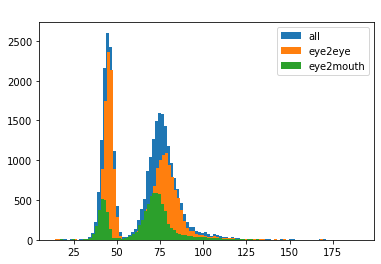

In [18]:
print(f'eye2eye: {eye2eye.sum()}, eye2mouth: {(~eye2eye).sum()}')
num_bins = 100
plt.figure()
plt.title('X norm')
plt.hist(x_norm, bins=num_bins, label='all')
plt.hist(x_norm[eye2eye], bins=num_bins, label='eye2eye')
plt.hist(x_norm[~eye2eye], bins=num_bins, label='eye2mouth')
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')
plt.show()

### X norm 與 C 的關係

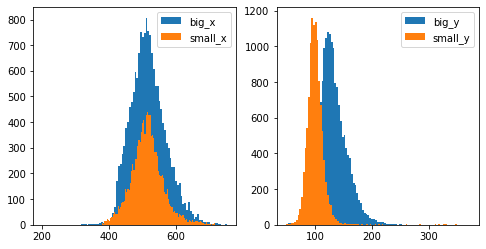

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(cs[x_norm >= 55, 0], bins=100, label='big_x')
ax[0].hist(cs[x_norm < 55, 0], bins=100, label='small_x')
legend = ax[0].legend()
plt.setp(legend.get_texts(), color='black')

ax[1].hist(cs[x_norm >= 55, 1], bins=100, label='big_y')
ax[1].hist(cs[x_norm < 55, 1], bins=100, label='small_y')
legend = ax[1].legend()
plt.setp(legend.get_texts(), color='black')

plt.show()

In [59]:
print('cx:', cs[:,0].mean(), cs[:,1].std())
print("big:", cs[x_norm >= 55, 1].mean(), cs[x_norm >= 55, 1].std())
print("small:", cs[x_norm < 55, 1].mean(), cs[x_norm < 55, 1].std())

cx: 517.0750810781593 26.65586335830469
big: 131.60036486486484 24.413869111828962
small: 100.36177146203046 17.22724347168094


### X 角度的統計
* 極座標 (rho, phi)
    * rho: `np.sqrt(x**2 + y**2)`
    * phi: `np.arctan2(y, x) % (2 * np.pi)`

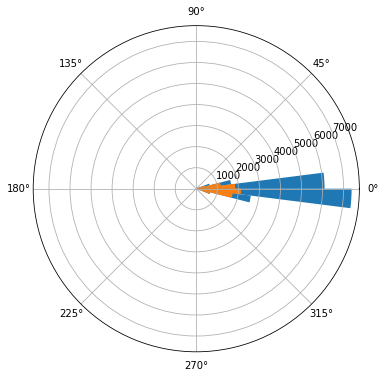

In [22]:
N = 50
width = (2*np.pi) / N
plt.subplots(figsize=(6,6))
ax = plt.subplot(111, polar=True)

X = xs[eye2eye]
phi = np.arctan2(X[:, 1], X[:, 0]) % (2 * np.pi)
radii, bins = np.histogram(phi, bins=N)
bars = (bins[1:] + bins[:-1]) / 2
_ = ax.bar(bars, radii, width=width, bottom=0, label='eye2eye')

X = xs[~eye2eye]
phi = np.arctan2(X[:, 1], X[:, 0]) % (2 * np.pi)
radii, bins = np.histogram(phi, bins=N)
bars = (bins[1:] + bins[:-1]) / 2
_ = ax.bar(bars, radii, width=width, bottom=0, label='eye2mouth')


# Use custom colors and opacity
# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.jet(r / 10.))
#     bar.set_alpha(0.8)

### Coefficient between X_norm & X_angle
x 角度與大小沒啥關係

In [23]:
X = xs#[eye2eye]
angle = np.arctan2(X[:, 1], X[:, 0]) % (2 * np.pi)
X_norm = np.linalg.norm(X, axis=1)
np.corrcoef(np.vstack([X_norm, angle]))

array([[ 1.        , -0.00462402],
       [-0.00462402,  1.        ]])

### plot c on 2D

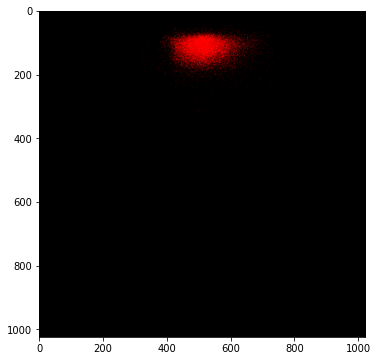

In [40]:
point_list = [cs.astype(int)]
fig, axs = plt.subplots(1, len(point_list), figsize=(6 * len(point_list), 6))
if len(point_list) == 1:
    axs = np.array([axs])
    
for ax, points in zip(axs, point_list):
    if isinstance(points, np.ndarray):
        points = [tuple(p) for p in points.tolist()]

    img = Image.new('RGB', (1024, 1024))
    imgd = ImageDraw.ImageDraw(img)
    imgd.point(points, fill="red")
    ax.imshow(np.array(img))

plt.show()

In [48]:
normalized_xs = xs / np.linalg.norm(xs, axis=1, keepdims=True)
phi = np.arctan2(normalized_xs[:, 1], normalized_xs[:, 0])
phi.max(), phi.min()

(0.7072690920196493, -0.7945954936491173)